# Fourier Neural Operator for 1-D Burger's Equation 
<!-- @script made by: Kai Chang -->

This script takes a deep look into the dataset for 1-dimensional Burger's equation used in [[Li et al., 2020]](https://arxiv.org/abs/2010.08895) and walks through the implementation of 1-D fourier neural operator. 

## Problem Statement
We intend to solve the equation

\begin{align}
\partial_t u(x,t) + \partial_x\left(u^2(x,t)/2\right) &= \nu\partial_{xx}u(x,t)\quad & x\in(0,1),t\in(0,1]\\
u(x,0) &= u_0(x) & x\in(0,1)
\end{align}

with periodic boundary conditions where $u_0 \in L^2\left((0,1);\mathbb{R}\right)$ is the initial conditio and $\nu\in \mathbb{R}_+$ is the viscosity coefficient. 

## Goal:
### To learn a map from the space of IC functions to the solution; i.e. $u_0(x) \mapsto u(x,t)$ where $x\in(0,1),t\in(0,1]$.


<!-- # Dataset

Let's first take a look at the dataset to get us better understand some of the technicalities in the implementation. It contains the solution to 1-d Burger's equation with different initial conditions. The dataset is generated by classical PDE solvers. The raw data is a dictionary. In this test case, `'input'` corresponds to the input and `'output'` is the ground truth. 

Here, the domain of the map we want to approximate is the space of initial conditions; the codomain is the space of the solutions.  -->

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities import *
from Adam import Adam
import random
from plot_lib import plot_loss, plt_set_default
import os

plt_set_default()

In [11]:
##########################################################################################
################################# Fourier Layer 2D #######################################
##########################################################################################

class FourierLayer2d(nn.Module):
    """
    2D Fourier layer. 
    
    ->input => FFT => multiplied by a (kernel) matrix => inverse FFT => add Wv_t => output
    """
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = Parameter(self.scale * torch.rand(in_channels, 
                                                          out_channels, 
                                                          self.modes1, 
                                                          self.modes2, 
                                                          dtype=torch.cfloat))
        
        self.weights2 = Parameter(self.scale * torch.rand(in_channels, 
                                                          out_channels, 
                                                          self.modes1, 
                                                          self.modes2, 
                                                          dtype=torch.cfloat))
        
        self.w = nn.Conv2d(in_channels, out_channels, 1)

    # Complex multiplication
    def compl_mul2d(self, input_, weights):
        # (batch, in_channel, x, y), (in_channel, out_channel, x, y) -> (batch, out_channel, x, y)
        return torch.einsum("bixy,ioxy->boxy", input_, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        # the reason of out_ft.size(3) = resolution//2 + 1 is because here we are using rfft
        # which takes the fact that the DFT of real modes is Hermitian
        # Therefore, only half of the entries needs to be stored.
        # This is also the reason that we are only doing multiplication half of the usual times
        out_ft = torch.zeros(batchsize, 
                             self.out_channels,  
                             x.size(-2),
                             x.size(-1)//2 + 1,
                             dtype=torch.cfloat, 
                             device=x.device)
        
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x1 = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        x2 = self.w(x)
        return x1 + x2
    
#####################################################################################
####################################### FNO2D #######################################
#####################################################################################
    
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super().__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = FourierLayer2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = FourierLayer2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = FourierLayer2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = FourierLayer2d(self.width, self.width, self.modes1, self.modes2)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        """
        x.size() = (batch, t_res, x_res, 3)
        channel: [u0(x), x, t]
        
        """
        x = self.fc0(x)
        # now shape becomes (batch, resolution_t, resolution_x, width)
        
        x = x.permute(0, 3, 1, 2)
        # now shape becomes (batch, width, resolution_t, resolution_x)
        
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # dataset adopts Dirichlet BC

        h1 = self.conv0(x)
        x = F.gelu(h1)

        h2 = self.conv1(x)
        x = F.gelu(h2)

        h3 = self.conv2(x)
        x = F.gelu(h3)

        h4 = self.conv3(x)
        x = h4

#         x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        # now shape becomes (batch, resolution_t, resolution_x, width)
        
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x # x.shape = (batch, resolution_t, resolution_x, 1)
        

In [6]:
import torch
import numpy as np
from utilities import *
import os

# read time-dependent solution data
file_path = "../data/Burgers/burgers_pino.mat"
dataloader = MatReader(file_path)
print(dataloader.data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'N', 'a', 'ans', 'gamma', 'input', 'j', 'k', 'output', 's', 'sigma', 'steps', 'tau', 'tspan', 'None', 'u0eval', 'visc', 'x', '__function_workspace__'])


/workspace/kai/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [7]:
# separate input and ground truth
a_raw_data = dataloader.read_field('input') # a_raw_data.size() = (N_samples, x_res)
u_data = dataloader.read_field('output') # u_data.size() = (N_samples, t_res, x_res)
shape = u_data.size()
n_samples, size_t, size_x = shape[0], shape[1], shape[2]

a_raw_data = a_raw_data.reshape(n_samples, 1, size_x, 1).repeat([1, size_t, 1, 1])
gridt = torch.tensor(np.linspace(0, 1, size_t), dtype=torch.float)
gridt = gridt.reshape(1, size_t, 1, 1).repeat([n_samples, 1, size_x, 1])
gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
gridx = gridx.reshape(1, 1, size_x, 1).repeat([n_samples, size_t, 1, 1])

a_data = torch.cat((a_raw_data, gridx,  gridt), dim=-1) 
# a_data.size() = (n_samples, t_res, x_res, #channel=3)
# channel = (u0(x), x, t)

print(a_data.size()) 
print(u_data.size())

torch.Size([1200, 101, 128, 3])
torch.Size([1200, 101, 128])


In [8]:
sub_train = 2**0
sub_test = 2**0
n_train = 1000
n_test = 200
assert n_samples >= (n_train + n_test)

time_full_res = size_t
space_full_res = size_x

time_train_res = time_full_res // sub_train
space_train_res = space_full_res // sub_train

time_test_res = time_full_res // sub_test
space_test_res = space_full_res // sub_test

# sample data
a_train = a_data[:n_train,::sub_train, ::sub_train, :]
u_train = u_data[:n_train,::sub_train, ::sub_train]
a_test = a_data[-n_test:,::sub_test, ::sub_test, :]
u_test = u_data[-n_test:,::sub_test, ::sub_test]

print(a_train.size())
print(u_train.size())
print(a_test.size())
print(u_test.size())

torch.Size([1000, 101, 128, 3])
torch.Size([1000, 101, 128])
torch.Size([200, 101, 128, 3])
torch.Size([200, 101, 128])


2368001


<IPython.core.display.Javascript object>


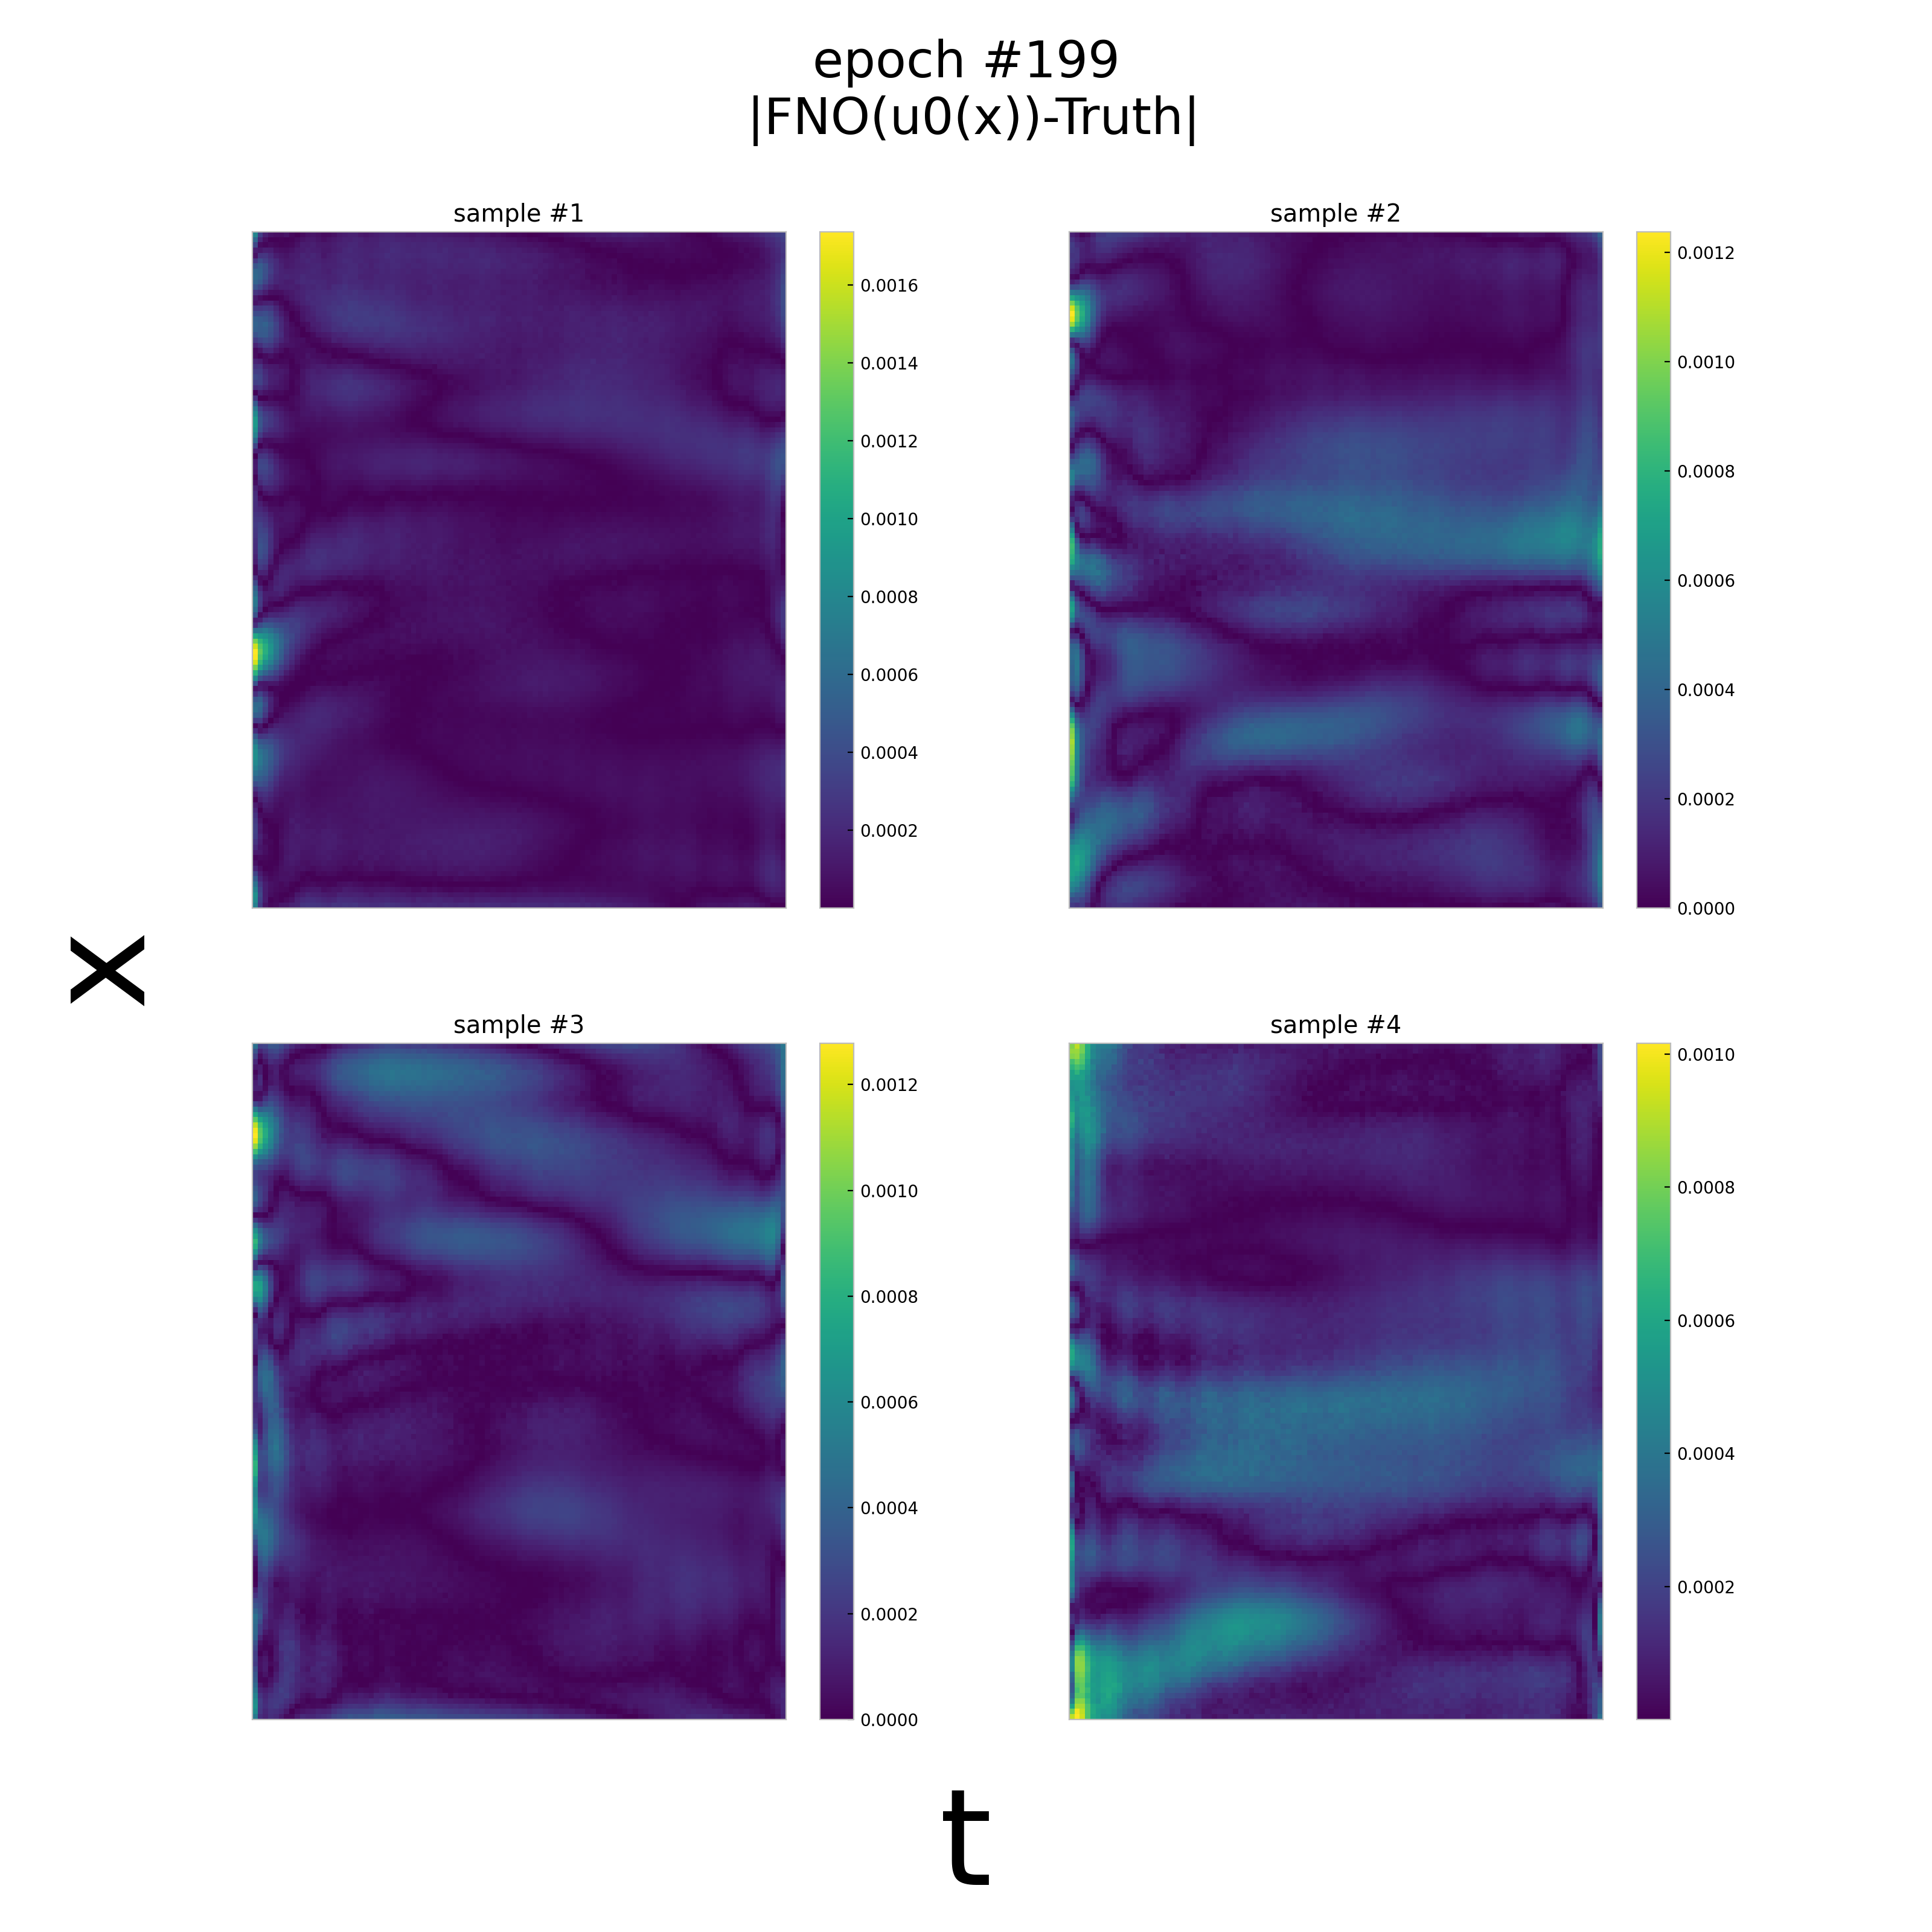

epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
0		2.22140 		0.76960 	 0.20794


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
25		1.87230 		0.01880 	 0.01338


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
50		1.82746 		0.00777 	 0.00792


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
75		1.76136 		0.00818 	 0.00579


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
100		2.50345 		0.00501 	 0.00351


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
125		1.82030 		0.00569 	 0.00548


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
150		2.04333 		0.00266 	 0.00267


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
175		2.04159 		0.00280 	 0.00288


epoch 		 t2-t1 		 train-L2-Error 	 test-L2-Error
199		1.99427 		0.00268 	 0.00256




In [37]:
%matplotlib notebook

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

###################################################
################## model configs ##################
###################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 20
learning_rate = 0.001
epochs = 200

# for scheduler's use 
# for every <step_size> epochs, the learning rate will be multiplied by <gamma>
step_size = 50
gamma = 0.5
modes = 12
width = 32

model = FNO2d(modes, modes, width).to(device)
print(count_params(model))

optimizer = Adam(model.parameters(), 
                 lr=learning_rate, 
                 weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=step_size,
                                            gamma=gamma)
myloss = LpLoss()#size_average=False) # default is relative L2 norm

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(a_train, u_train), 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(a_test, u_test), 
                                          batch_size=batch_size, 
                                          shuffle=False)
train_L2_Loss = []
test_L2_Loss = []

####################################################
################# plotting configs #################
####################################################

rows,cols = 2,2
num_plots = rows * cols
num_train_batch = n_train//batch_size
num_test_batch = n_test//batch_size
assert num_test_batch >= num_plots
sampled_batch_idx = random.sample(range(num_test_batch),num_plots)
sampled_plotting_idx = np.random.randint(batch_size, size = num_plots)


# if true, plot output solution; else plot absolute difference
plot_sol = False
if plot_sol:
    fig_sol = plt.figure(figsize = (16,16))
else:  
    fig_diff = plt.figure(figsize = (16,16))
plot_pos = 1

# xlabel = 'training resolution: ' + str(train_res) + '\n' + \
#          'testing resolution: ' + str(test_res)

# config for saving figures
saveFigSol = False
saveFigDiff = True

fig_folder = 'ep' + str(epochs) + \
             '-lr' + "".join(str(learning_rate).split('.')) + \
             '-decay' + "".join(str(gamma).split('.'))# + \
#              '-trainRes' + str(train_res) + \
#              '-testRes' + str(test_res)

fig_dir = '../figs/burgers-time/' + fig_folder
if saveFigDiff or saveFigSol:
    if not os.path.isdir(fig_dir):
        os.makedirs(fig_dir)

for ep in range(epochs):
    if plot_sol:
        fig_sol.clear()
        fig_sol.suptitle('epoch #' + str(ep) + '\n 1-D Time-Dependent Burgers \n FNO(u0(x))',fontsize = 30)
        fig_sol.supxlabel('t', fontsize=80)
        fig_sol.supylabel('x', fontsize=80)
    else:
        fig_diff.clear()
        fig_diff.suptitle('epoch #' + str(ep) + '\n |FNO(u0(x))-Truth|',fontsize = 30)
        fig_diff.supxlabel('t', fontsize=80)
        fig_diff.supylabel('x', fontsize=80)
        
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for batch, (a, u) in enumerate(train_loader):
        a, u = a.to(device), u.to(device)
        # a.shape = (batch, train_res, train_res, 1)
        # u.shape = (batch, train_res, train_res)
    
        optimizer.zero_grad()
        out = model(a).reshape(batch_size, time_train_res, space_train_res)
        # out.shape = (batch, time_train_res, space_train_res, 1)
        
        # out = u_normalizer.decode(out)
        # u = u_normalizer.decode(u)

        loss = myloss(out.view(batch_size,-1), u.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for batch, (a, u) in enumerate(test_loader):
            a, u = a.to(device), u.to(device)
            # a.shape = (batch, train_res, train_res, 1)
            # u.shape = (batch, train_res, train_res)

            out = model(a).reshape(batch_size, time_test_res, space_test_res)
            # out = u_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), u.view(batch_size,-1)).item()
            
            ### plot sampled testing function ###
            if plot_sol:
                if batch in sampled_batch_idx:
                    idx = sampled_plotting_idx[plot_pos-1]

                    # plot outputs of several sampled inputs
                    ax = fig_sol.add_subplot(rows,cols,plot_pos)
                    ax.clear()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)

                    out_sample = out[idx,:,:].reshape((time_test_res,space_test_res,1)).permute(1,0,2)
                    out_sample = out_sample.detach().cpu().numpy()
                    im = ax.imshow(out_sample)
                    ax.set_title(f"sample #{plot_pos}")
                    plt.colorbar(im)
                    
                    plot_pos += 1
                    
            else:
                if batch in sampled_batch_idx:
                    idx = sampled_plotting_idx[plot_pos-1]
                    
                    # plot absolute difference between the outputs and ground truth
                    ax2 = fig_diff.add_subplot(rows,cols,plot_pos)
                    ax2.clear()
                    ax2.get_xaxis().set_visible(False)
                    ax2.get_yaxis().set_visible(False)
                    truth_sample = u[idx,:,:].reshape((time_test_res,space_test_res,1)).permute(1,0,2)
                    out_sample = out[idx,:,:].reshape((time_test_res,space_test_res,1)).permute(1,0,2)
                    
                    diff_sample = torch.abs(truth_sample.detach() - out_sample.detach()) \
                                  .detach().cpu().numpy()
                    im2 = ax2.imshow(diff_sample)
                    ax2.set_title(f"sample #{plot_pos}")

                    plot_pos += 1
                    plt.colorbar(im2)
        
        if plot_sol:
            fig_sol.canvas.draw()
        else:
            fig_diff.canvas.draw()
        plot_pos = 1
        
        if plot_sol and saveFigSol:
            if fig_dir[-1] != '/':
                fig_dir = fig_dir + '/'
            fig_sol_dir = fig_dir + 'sol/'
            if not os.path.isdir(fig_sol_dir):
                os.makedirs(fig_sol_dir)
            fig_sol_name = fig_sol_dir + 'epoch-' + str(ep) + '.png'
            fig_sol.savefig(fig_sol_name)
        
        if (not plot_sol) and saveFigDiff:
            if fig_dir[-1] != '/':
                fig_dir = fig_dir + '/'
            fig_diff_dir = fig_dir + 'diff/'
            if not os.path.isdir(fig_diff_dir):
                os.makedirs(fig_diff_dir)
            fig_diff_name = fig_diff_dir + 'epoch-' + str(ep) + '.png'
            fig_diff.savefig(fig_diff_name)
        
    train_l2 /= num_train_batch
    train_L2_Loss.append(train_l2)
    
    test_l2 /= num_test_batch
    test_L2_Loss.append(test_l2)

    t2 = default_timer()
    if ep%25 == 0 or ep == (epochs-1):
        print('epoch \t\t t2-t1 \t\t train-L2-Error \t test-L2-Error')
        print('{0:d}\t\t{1:.5f} \t\t{2:.5f} \t {3:.5f}' \
              .format(ep, t2-t1, train_l2, test_l2))
        print('\n')

<IPython.core.display.Javascript object>


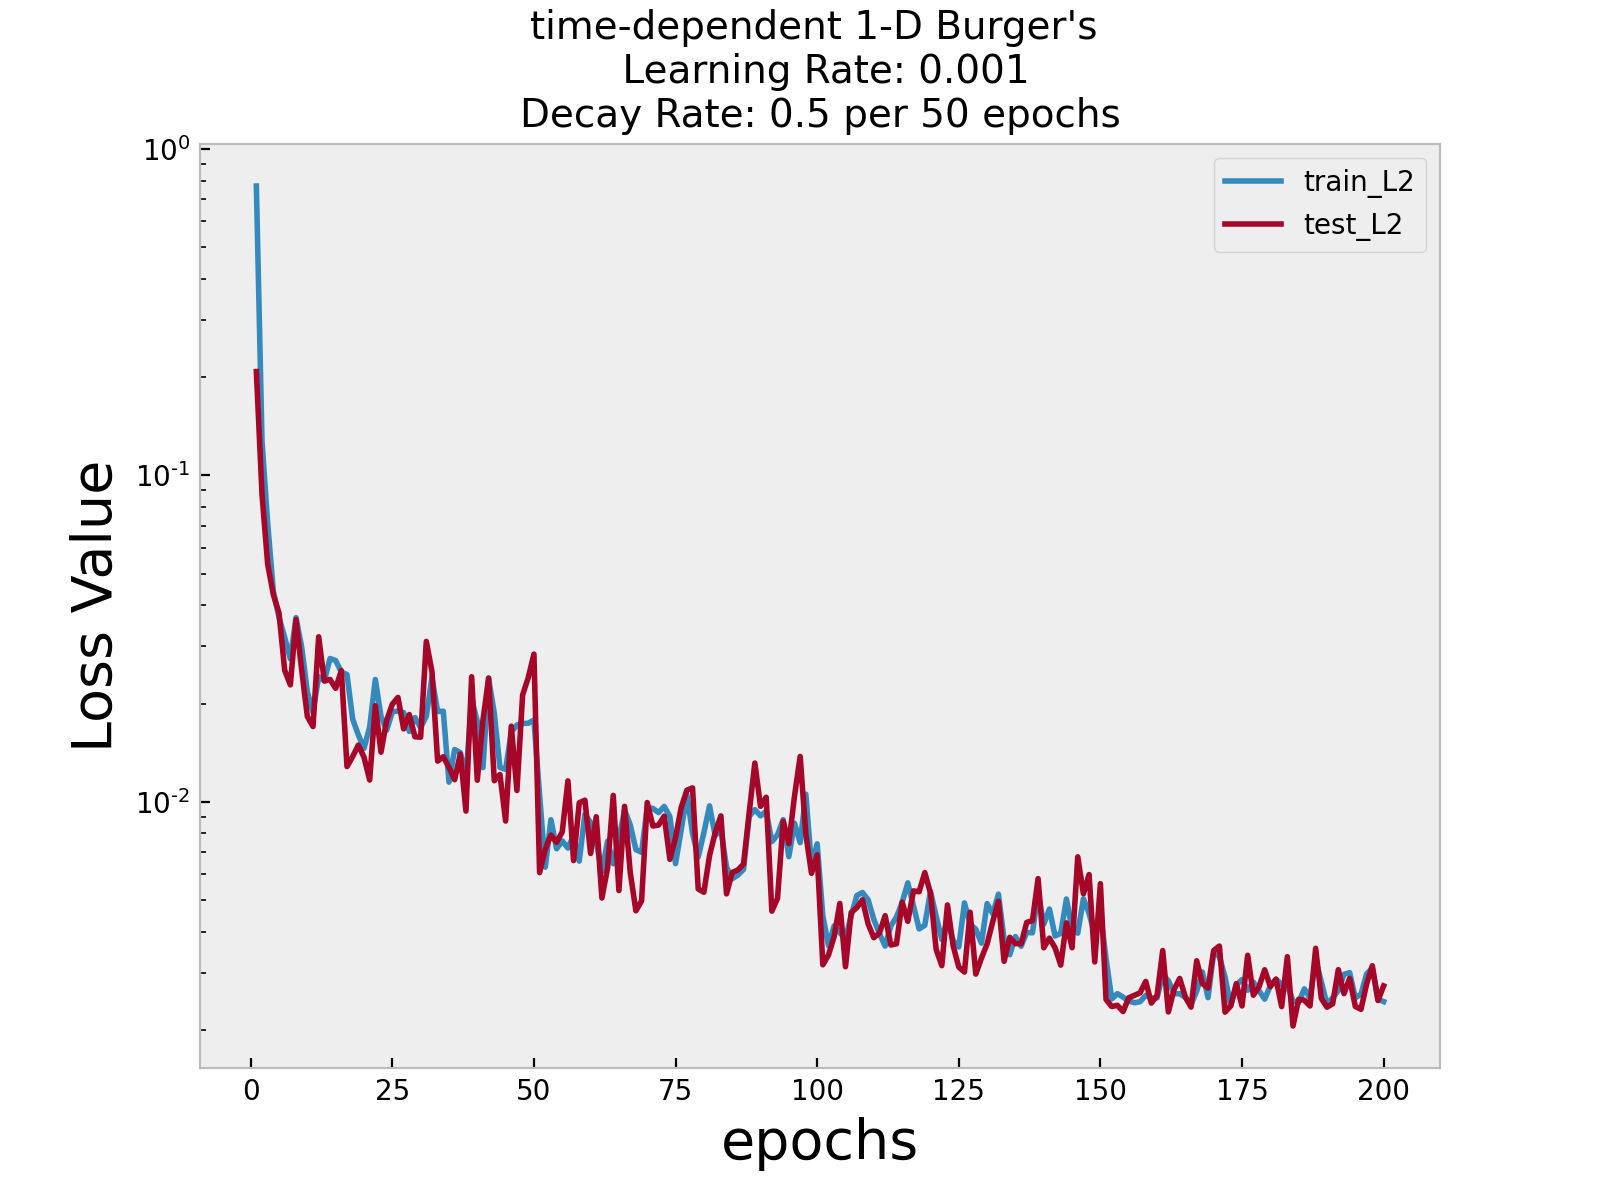

In [36]:
saveLossFig = True
lossfig_path = '../figs/burgers-time/loss/'
lossfig_name = 'ep' + str(epochs) + \
               '-lr' + "".join(str(learning_rate).split('.')) + \
               '-decay' + "".join(str(gamma).split('.'))# + \
#                '-trainRes' + str(train_res) + \
#                '-testRes' + str(test_res)

figtitle = 'time-dependent 1-D Burger\'s \n Learning Rate: ' + str(learning_rate) + '\n' + \
           'Decay Rate: ' + str(gamma) + ' per ' + str(step_size) + ' epochs'
plot_loss(figtitle = figtitle,
          figpath = lossfig_path, 
          figname = lossfig_name,
          savefig = saveLossFig, 
          train_L2 = train_L2_Loss, 
          test_L2 = test_L2_Loss)